### Download dataset

In [ ]:
import kagglehub
import os
path = kagglehub.dataset_download("mohamedmaher5/vehicle-classification")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
path += "/Vehicles"

In [ ]:
path

'/kaggle/input/vehicle-classification/Vehicles'

### Load the dataset dir using pytorch dataset class

In [ ]:
class VehicleDS(Dataset):
    def __init__(self, directory, transform=None):
        self.data = ImageFolder(directory, transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    def classes(self):
        return self.data.classes

In [ ]:
# resize images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [ ]:
dataset = VehicleDS(path, transform=transform)

In [ ]:
# Train, validation split
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset)-int(0.8*len(dataset))])

In [ ]:
label_map = {i: n for n, i in ImageFolder(path).class_to_idx.items()}

In [ ]:
img, label = dataset[900]
img.shape

torch.Size([3, 128, 128])

In [ ]:
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
for image , label in train_data_loader:
    print(image.shape)
    print(label.shape)
    break

torch.Size([32, 3, 128, 128])
torch.Size([32])


In [ ]:
class Model(nn.Module):
    def __init__(self, num_classes=7):
        super(Model, self).__init__()
        self.base_model = timm.create_model('resnet18', pretrained=True)
        # remove the last layer which has output shape
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        # custom output shape
        self.classifier = nn.Linear(512, num_classes)


    def forward(self, x):
        out = self.features(x)
        out = self.classifier(out)
        return out

In [ ]:
model =Model(num_classes=7)

In [ ]:
model(image).shape

torch.Size([32, 7])

In [ ]:
!nvidia-smi

Tue Jun  3 20:54:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# optimizer and loss functions with default parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act1): ReLU(inplace=True)
        (aa): Identity()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

### Training

In [ ]:
model.to(device)
train_losses = []
val_losses = []
for epoch in range(10):
    model.train()
    loss_per_epoch = 0
    for images,labels in tqdm(train_data_loader, desc="training loop"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward() #weights
        optimizer.step() #forward
        loss_per_epoch += loss.item() * images.size(0)
    train_loss = loss_per_epoch / len(train_dataset)
    train_losses.append(train_loss)

    #validation
    model.eval()
    loss_per_epoch = 0
    with torch.no_grad():
        for images, labels in tqdm(val_data_loader, desc="validation loop"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss_per_epoch += loss.item() * images.size(0)
    val_loss = loss_per_epoch / len(val_dataset)

    print(f"Epoch {epoch+1}/{10}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    val_losses.append(val_loss)

training loop:  24%|██▎       | 33/140 [00:20<00:50,  2.12it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
validation loop: 100%|██████████| 35/35 [00:20<00:00,  1.74it/s]


Epoch 1/6, Train Loss: 0.4503, Val Loss: 0.1373


validation loop: 100%|██████████| 35/35 [00:13<00:00,  2.51it/s]


Epoch 2/6, Train Loss: 0.1024, Val Loss: 0.1361


validation loop: 100%|██████████| 35/35 [00:14<00:00,  2.40it/s]


Epoch 3/6, Train Loss: 0.0490, Val Loss: 0.1692


validation loop: 100%|██████████| 35/35 [00:14<00:00,  2.39it/s]


Epoch 4/6, Train Loss: 0.0277, Val Loss: 0.1127


validation loop: 100%|██████████| 35/35 [00:15<00:00,  2.31it/s]


Epoch 5/6, Train Loss: 0.0284, Val Loss: 0.1688


validation loop: 100%|██████████| 35/35 [00:14<00:00,  2.48it/s]

Epoch 6/6, Train Loss: 0.0484, Val Loss: 0.1482


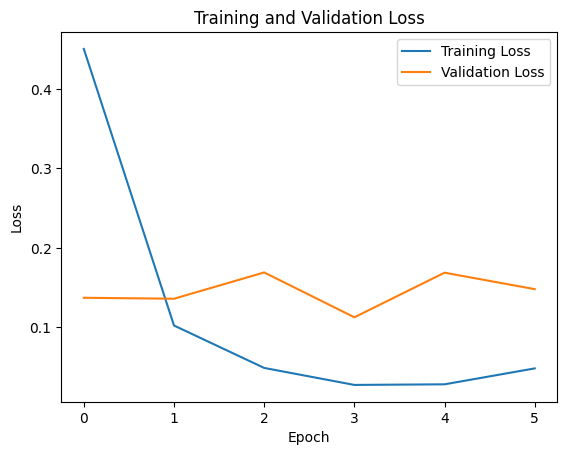

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

### Use the model on some random images

In [ ]:
import urllib.request
from PIL import Image

img_urls = ["https://robbreport.com/wp-content/uploads/2024/08/temerario01.jpg?w=300", "https://hips.hearstapps.com/hmg-prod/images/future-cars-679d3400f197f.jpg?crop=1.00xw:0.899xh;0,0.0575xh&resize=300:*", "https://images.dassault-aviation.com/f_auto,q_auto,g_center,dpr_auto/wp-auto-upload/2/files/2015/02/W1I0345-1.jpg", "https://cdn.bikedekho.com/processedimages/yamaha/mt-15-2-0/source/mt-15-2-06613f885e681c.jpg", "https://electricvehicles.in/wp-content/uploads/2020/12/Top-5-Electric-Auto-Rickshaw-in-India.jpg"]

for i in range(len(img_urls)):
    urllib.request.urlretrieve(img_urls[i], f"test_image{i}.jpg")
    img = Image.open(f"test_image{i}.jpg")
    img.show()

In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image

def predict(image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        output = model(image_tensor)
        probabilities  = nn.functional.softmax(output, dim=1)
    return probabilities.cpu().numpy().flatten()

probabilities = [predict(preprocess_image(f"test_image{i}.jpg")) for i in range(len(img_urls))]

In [ ]:
probabilities_ = [list(i) for i in probabilities]
probabilities_
predictions = [list(label_map.values())[probabilities_[i].index(max(probabilities_[i]))] for i in range(len(probabilities_))]

['Cars', 'Cars', 'Planes', 'Motorcycles', 'Auto Rickshaws']

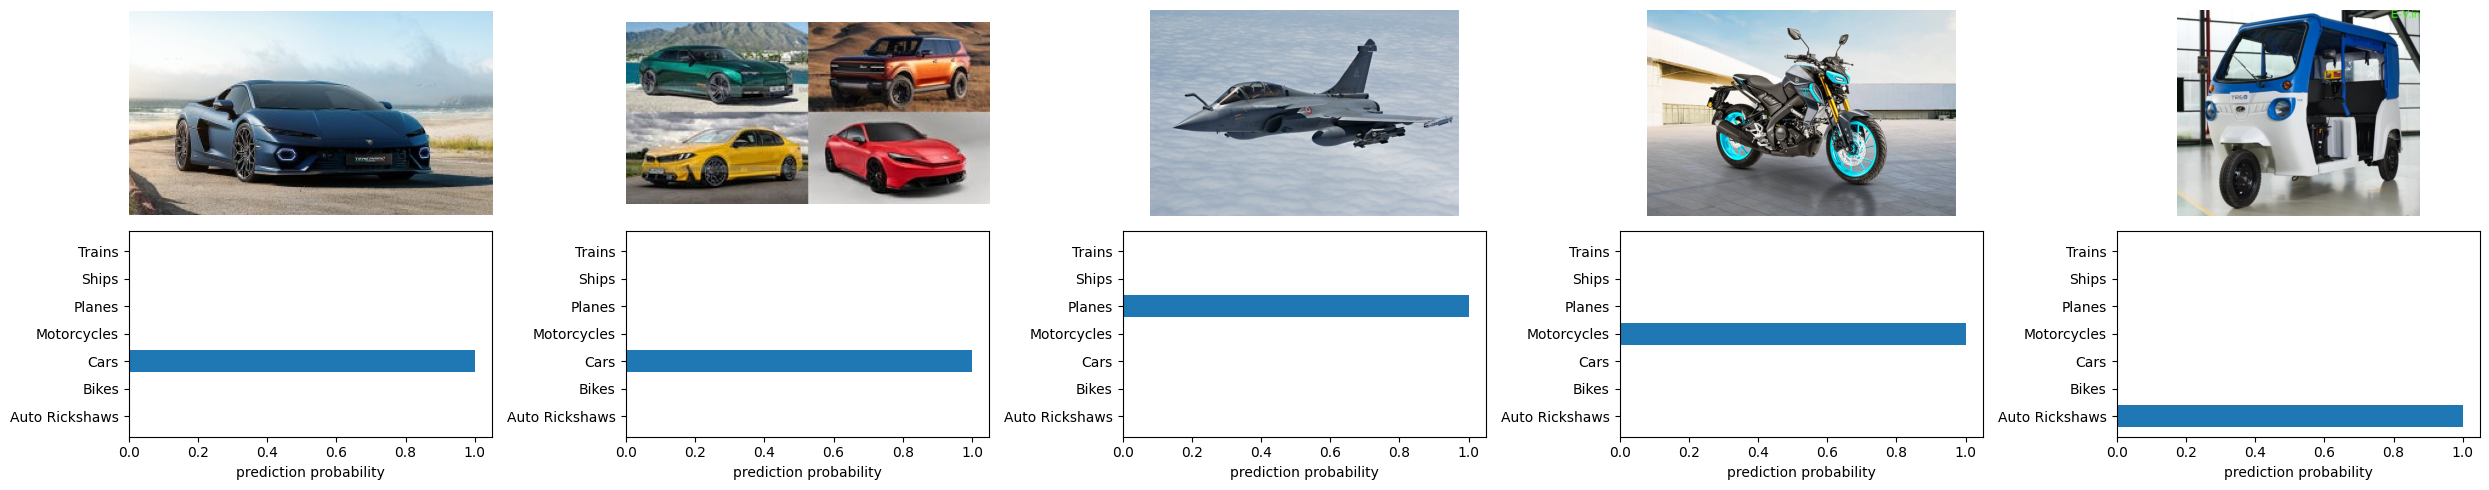

In [ ]:
fig, axarr = plt.subplots(2, 5, figsize=(25,5))
for i in range(len(img_urls)):
    axarr[0][i].imshow(Image.open(f"test_image{i}.jpg"))
    axarr[0][i].axis("off")

    axarr[1][i].barh(list(label_map.values()), probabilities_[i])
    axarr[1][i].set_xlabel("prediction probability")
plt.tight_layout()


### Calculating Accuracy

In [ ]:
model.to(device)
model.eval()
correct_predictions = 0
total_samples = 0
with torch.no_grad():
    for images, labels in tqdm(val_data_loader):
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted_class = torch.max(output, 1)
        correct_predictions += sum([labels[i].item() == predicted_class[i].item() for i in range(len(labels))])
        total_samples += len(labels)



100%|██████████| 35/35 [00:14<00:00,  2.47it/s]


In [ ]:
print(f"Accuracy: {correct_predictions/total_samples*100}%")

Accuracy: 96.06440071556351%
